In [5]:
r"""# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'icv83551/assignments/assignment1/'
FOLDERNAME = 'icv83551/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/icv83551/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME"""

'# This mounts your Google Drive to the Colab VM.\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# TODO: Enter the foldername in your Drive where you have saved the unzipped\n# assignment folder, e.g. \'icv83551/assignments/assignment1/\'\nFOLDERNAME = \'icv83551/assignments/assignment1/\'\nassert FOLDERNAME is not None, "[!] Enter the foldername."\n\n# Now that we\'ve mounted your Drive, this ensures that\n# the Python interpreter of the Colab VM can load\n# python files from within it.\nimport sys\nsys.path.append(\'/content/drive/My Drive/{}\'.format(FOLDERNAME))\n\n# This downloads the CIFAR-10 dataset to your Drive\n# if it doesn\'t already exist.\n%cd /content/drive/My\\ Drive/$FOLDERNAME/icv83551/datasets/\n!bash get_datasets.sh\n%cd /content/drive/My\\ Drive/$FOLDERNAME'

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [6]:
import random
import numpy as np
from icv83551.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#%load_ext autoreload
#%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [7]:
from icv83551.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'icv83551/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [8]:
from icv83551.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [9]:
# Use the validation set to tune the learning rate and regularization strength

from icv83551.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 1e-6, 5e-6, 1e-5, 5e-5]
regularization_strengths = [1e5, 5e4, 1e5, 5e5, 5e6, 1e7, 5e7]
learning_rates = np.linspace(start=1e-8, stop=1e-3, num=10)
regularization_strengths =  np.linspace(start=1, stop=5e7, num=20)
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################
options = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]

for lr, reg in options:
    
    softmax_cls = Softmax()

    softmax_cls.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=150)

    y_val_pred = softmax_cls.predict(X_val_feats)
    y_train_pred = softmax_cls.predict(X_train_feats)

    val_acc = np.mean(y_val == y_val_pred)
    train_acc = np.mean(y_train == y_train_pred)
    
    results[((lr, reg))] = (train_acc, val_acc)

    if val_acc > best_val:
        best_val = val_acc
        best_softmax = softmax_cls

    print(lr, reg, val_acc)



# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

1e-08 1.0 0.13
1e-08 2631579.8947368423 0.095
1e-08 5263158.7894736845 0.394
1e-08 7894737.684210527 0.415
1e-08 10526316.578947369 0.401
1e-08 13157895.47368421 0.382
1e-08 15789474.368421054 0.399
1e-08 18421053.263157897 0.376
1e-08 21052632.157894738 0.399
1e-08 23684211.05263158 0.351
1e-08 26315789.94736842 0.367
1e-08 28947368.842105266 0.358
1e-08 31578947.736842107 0.359
1e-08 34210526.63157895 0.354
1e-08 36842105.52631579 0.358
1e-08 39473684.421052635 0.341
1e-08 42105263.315789476 0.349
1e-08 44736842.21052632 0.348
1e-08 47368421.10526316 0.336
1e-08 50000000.0 0.358
0.00011112 1.0 0.291
0.00011112 2631579.8947368423 0.087


c:\Users\royek\Documents\Courses\computer-vision-alexandra\assignment1\icv83551\classifiers\softmax.py:81: RuntimeWarning: divide by zero encountered in log
  logp = np.log(p)
c:\Users\royek\Documents\Courses\computer-vision-alexandra\assignment1\icv83551\classifiers\softmax.py:87: RuntimeWarning: overflow encountered in scalar multiply
  loss = -np.sum(logp[np.arange(num_train), y]) / num_train + reg * np.sum(W * W)
c:\Users\royek\Documents\Courses\computer-vision-alexandra\assignment1\icv83551\classifiers\softmax.py:87: RuntimeWarning: overflow encountered in multiply
  loss = -np.sum(logp[np.arange(num_train), y]) / num_train + reg * np.sum(W * W)
c:\Users\royek\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\royek\Documents\Courses\computer-vision-alexandra\assignment1\icv83551\classifiers\softmax.py:88: RuntimeWarning: overflow encountered in multiply
  dW 

0.00011112 5263158.7894736845 0.087
0.00011112 7894737.684210527 0.087
0.00011112 10526316.578947369 0.087
0.00011112 13157895.47368421 0.087
0.00011112 15789474.368421054 0.087
0.00011112 18421053.263157897 0.087
0.00011112 21052632.157894738 0.087
0.00011112 23684211.05263158 0.087
0.00011112 26315789.94736842 0.087
0.00011112 28947368.842105266 0.087
0.00011112 31578947.736842107 0.087
0.00011112 34210526.63157895 0.087
0.00011112 36842105.52631579 0.087
0.00011112 39473684.421052635 0.087
0.00011112 42105263.315789476 0.087
0.00011112 44736842.21052632 0.087
0.00011112 47368421.10526316 0.087
0.00011112 50000000.0 0.087
0.00022223000000000002 1.0 0.351
0.00022223000000000002 2631579.8947368423 0.087
0.00022223000000000002 5263158.7894736845 0.087
0.00022223000000000002 7894737.684210527 0.087
0.00022223000000000002 10526316.578947369 0.087
0.00022223000000000002 13157895.47368421 0.087
0.00022223000000000002 15789474.368421054 0.087
0.00022223000000000002 18421053.263157897 0.087
0

In [10]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.408


In [ ]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

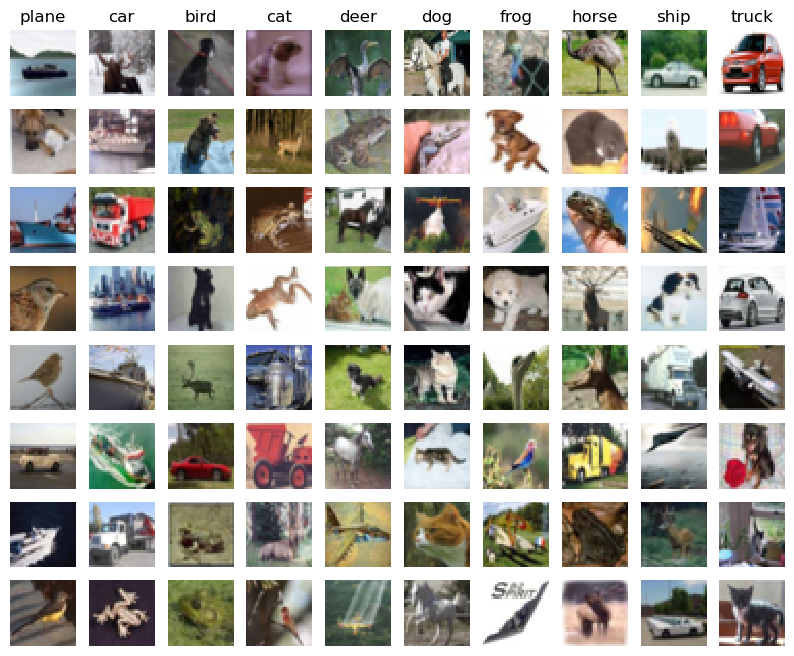

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ It seems thsat im most cases there isnt much sanse of the missclassifications. Though some misscalasifications are understandable, like the network missclasifing a car as a truck and visa versa, alsoall of the animals are misscalsifing each other.





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
#X_train_feats = X_train_feats[:, :-1]
#X_val_feats = X_val_feats[:, :-1]
#X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [27]:
from icv83551.classifiers.fc_net import TwoLayerNet
from icv83551.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

lr_decay_options= [0.95, 0.90]
lr_options = [9e-1, 5e-1, 1e-1, 5e-2, 1e-2]
batch_size_options = [200]

best_accuracy = -1

options = [(lr, lr_decay, batch_size) for lr in lr_options for lr_decay in lr_decay_options for batch_size in batch_size_options]

for lr, lr_decay, batch_size in options:
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    solver = Solver(net, data,
                        update_rule='sgd',
                        optim_config={
                        'learning_rate': lr,
                        },
                        lr_decay=lr_decay,
                        num_epochs=10, batch_size=batch_size,
                        print_every=10000)

    solver.train()

    acc = solver.check_accuracy(data["X_val"], data["y_val"])

    if acc > best_accuracy:
        best_accuracy = acc
        best_net = solver.model
        print("best val accuracy is", best_accuracy)

    print((lr, lr_decay, batch_size), "===", acc)

print("best val accuracy is", best_accuracy)



(Iteration 1 / 2450) loss: 2.302588
(Epoch 0 / 10) train acc: 0.100000; val_acc: 0.087000
(Epoch 1 / 10) train acc: 0.535000; val_acc: 0.525000
(Epoch 2 / 10) train acc: 0.587000; val_acc: 0.488000
(Epoch 3 / 10) train acc: 0.627000; val_acc: 0.549000
(Epoch 4 / 10) train acc: 0.666000; val_acc: 0.555000
(Epoch 5 / 10) train acc: 0.692000; val_acc: 0.581000
(Epoch 6 / 10) train acc: 0.732000; val_acc: 0.548000
(Epoch 7 / 10) train acc: 0.736000; val_acc: 0.549000
(Epoch 8 / 10) train acc: 0.772000; val_acc: 0.555000
(Epoch 9 / 10) train acc: 0.794000; val_acc: 0.564000
(Epoch 10 / 10) train acc: 0.807000; val_acc: 0.560000
best val accuracy is 0.581
(0.9, 0.95, 200) === 0.581
(Iteration 1 / 2450) loss: 2.302599
(Epoch 0 / 10) train acc: 0.098000; val_acc: 0.112000
(Epoch 1 / 10) train acc: 0.535000; val_acc: 0.523000
(Epoch 2 / 10) train acc: 0.570000; val_acc: 0.534000
(Epoch 3 / 10) train acc: 0.596000; val_acc: 0.527000
(Epoch 4 / 10) train acc: 0.675000; val_acc: 0.578000
(Epoch 5 

In [28]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.583


In [30]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
